In [1]:
import os
import requests
import glob
import cv2 as cv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import random
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import nibabel as nib
import pydicom
import math

from path import Path
from tqdm import tqdm
import nibabel as nib
import pydicom as dicom
from pydicom import dcmread
from skimage import measure
from skimage.segmentation import clear_border
from skimage.measure import label,regionprops
from scipy import ndimage as ndi
from scipy.ndimage import measurements,center_of_mass,binary_dilation,zoom
import pickle

from tensorflow import keras
import tensorflow as tf
import tensorflow_hub as hub
from keras import layers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import StratifiedKFold
from pydicom.pixel_data_handlers.util import apply_voi_lut
from keras_preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda,Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
kernel_initializer =  'he_uniform'

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train_b = pd.read_csv("train_bounding_boxes.csv")
submission = pd.read_csv("sample_submission.csv")

In [3]:
test

,row_id,StudyInstanceUID,prediction_type
0,1.2.826.0.1.3680043.10197_C1,1.2.826.0.1.3680043.10197,C1
1,1.2.826.0.1.3680043.10454_C1,1.2.826.0.1.3680043.10454,C1
2,1.2.826.0.1.3680043.10690_C1,1.2.826.0.1.3680043.10690,C1


In [4]:
train.sort_values('StudyInstanceUID',inplace=True,axis = 0)
train_b.sort_values('StudyInstanceUID',inplace=True,axis = 0)
train.reset_index(inplace=True,drop= True)
train_b.reset_index(inplace=True,drop= True)

In [5]:
train_dir =r"D:\Projects\Kaggle\RSNA\train_images"
test_dir =r"D:\Projects\Kaggle\RSNA\test_images"
seg_dir =r"D:\Projects\Kaggle\RSNA\segmentations"

In [6]:
patients = os.listdir(train_dir)

# General EDA  

D:\Projects\Kaggle\RSNA\train_images\1.2.826.0.1.3680043.10001\150.dcm
D:\Projects\Kaggle\RSNA\train_images\1.2.826.0.1.3680043.10001\151.dcm
D:\Projects\Kaggle\RSNA\train_images\1.2.826.0.1.3680043.10001\152.dcm
D:\Projects\Kaggle\RSNA\train_images\1.2.826.0.1.3680043.10001\153.dcm
D:\Projects\Kaggle\RSNA\train_images\1.2.826.0.1.3680043.10001\154.dcm
D:\Projects\Kaggle\RSNA\train_images\1.2.826.0.1.3680043.10001\155.dcm
D:\Projects\Kaggle\RSNA\train_images\1.2.826.0.1.3680043.10001\156.dcm
D:\Projects\Kaggle\RSNA\train_images\1.2.826.0.1.3680043.10001\157.dcm
D:\Projects\Kaggle\RSNA\train_images\1.2.826.0.1.3680043.10001\158.dcm
D:\Projects\Kaggle\RSNA\train_images\1.2.826.0.1.3680043.10001\159.dcm
D:\Projects\Kaggle\RSNA\train_images\1.2.826.0.1.3680043.10001\160.dcm
D:\Projects\Kaggle\RSNA\train_images\1.2.826.0.1.3680043.10001\161.dcm
D:\Projects\Kaggle\RSNA\train_images\1.2.826.0.1.3680043.10001\162.dcm
D:\Projects\Kaggle\RSNA\train_images\1.2.826.0.1.3680043.10001\163.dcm
D:\Pro

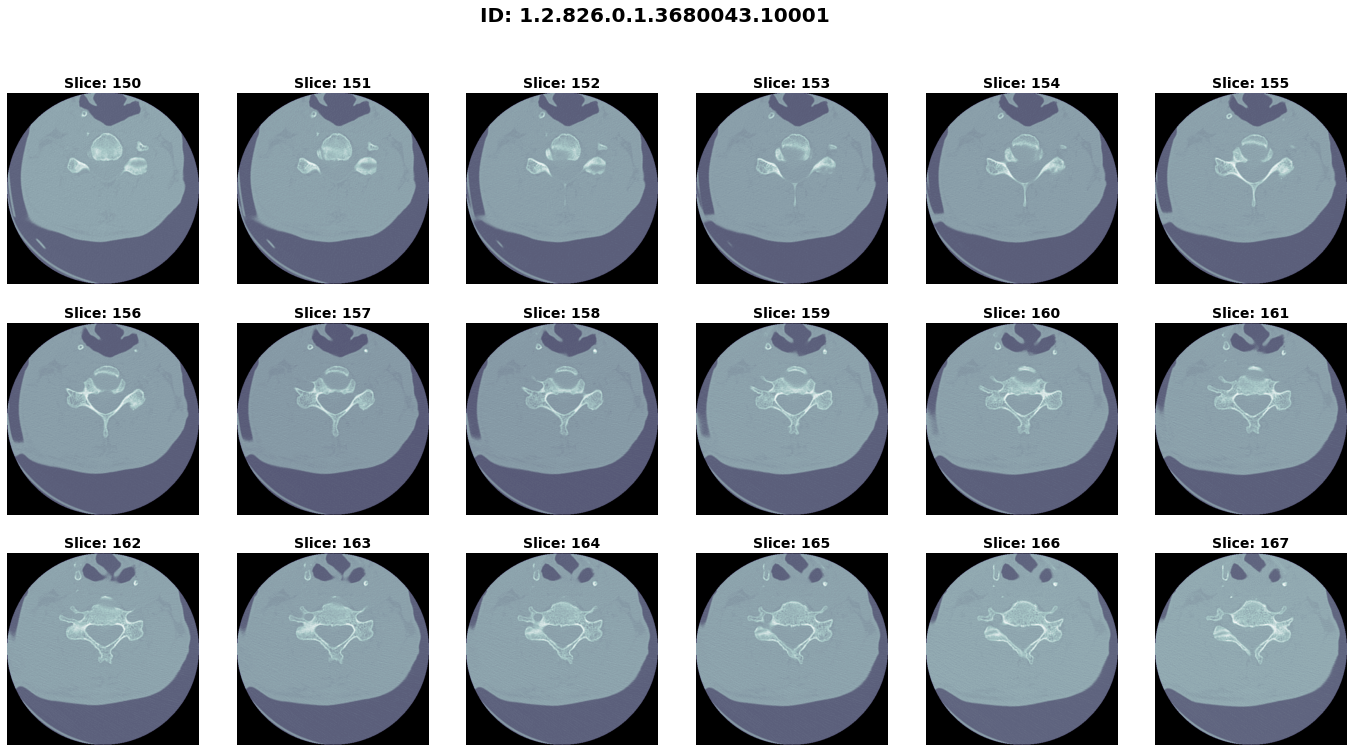

In [7]:
images=[]
for p in patients[:1]:
    dir = os.path.join(train_dir,p)
    FileName = os.listdir(os.path.join(train_dir,p))
    for index in range(150,168):
        sec = str(index)+'.dcm'
        image_path= os.path.join(dir,sec)
        print(image_path)
        images.append(image_path)
        # print(len(FileName),images.pixel_array.shape)
        # plt.pcolormesh(image.pixel_array)
        # plt.colorbar()
        # plt.show()
    fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(24,12))
    fig.suptitle(f'ID: {p}', weight="bold", size=20)

    j=0
    for i in range(150,168,1):
        slice_no = i
        # Plot the image
        x = (j) // 6
        y = (j) % 6
        img = dicom.dcmread(images[j])
        j+=1
        axes[x, y].imshow(img.pixel_array, cmap="bone")
        axes[x, y].set_title(f"Slice: {slice_no}", fontsize=14, weight='bold')
        axes[x, y].axis('off')


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import animation, rc; rc('animation', html='jshtml')
import re
import os
import cv2
import gc
from glob import glob
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

In [ ]:
def create_animation(patient_id, drc='train_images', save_dir="D:\Projects\Kaggle\RSNA", save=True, fps=10):
    # Get paths
    base_path = "D:\Projects\Kaggle\RSNA"
    dcm_paths = glob(f"{base_path}/{drc}/{patient_id}/*")
    def atoi(text):
        return int(text) if text.isdigit() else text
    def natural_keys(text):
        return [atoi(c) for c in re.split(r'(\d+)', text)]
    dcm_paths.sort(key=natural_keys)
    
    # Get images
    files = [pydicom.dcmread(path) for path in dcm_paths]
    images = [apply_voi_lut(file.pixel_array, file) for file in files]
    
    # Optimise memory
    images_small = [np.clip(cv2.resize(img,dsize=[256,256]),-32768,32767).astype('int16') for img in images]
    
    # Stack images
    animation_arr = np.stack(images_small, axis=0)

    del images, images_small
    gc.collect()
    
    # Initialise plot
    fig = plt.figure(figsize=(3,3))  # if size is too big then gif gets truncated
    im = plt.imshow(animation_arr[0], cmap='bone')
    plt.axis('off')
    plt.title(f"{patient_id}", fontweight="bold")
    
    # Load next frame
    def animate_func(i):
        im.set_array(animation_arr[i])
        return [im]
    plt.close()
    
    # Animation function
    anim = animation.FuncAnimation(fig, animate_func, frames = animation_arr.shape[0], interval = 1000//fps)
    
    # Save
    if save:
        os.makedirs(save_dir, exist_ok=True)
        anim.save(os.path.join(save_dir, f"patient_{patient_id}.gif"), fps=10, writer='imagemagick')
        
    return anim

In [ ]:
create_animation('1.2.826.0.1.3680043.18659', fps=30)

In [ ]:
absolute_path = 'D:\Projects\Kaggle\RSNA\segmentations'
base_path = os.path.join(absolute_path)
full_directory = glob(os.path.join(absolute_path, '*'))
print(full_directory)

# NOT SO GOOD GIF CODE

In [ ]:
def create_gif(input_image, title='.gif', filename='test.gif'):
    # see example from matplotlib documentation
    import imageio
    import matplotlib.animation as animate
    images = []
    input_image_data = input_image.get_fdata()
    fig = plt.figure()
    for i in range(len(input_image_data)):
        im = plt.imshow(input_image_data[i], animated=True)
        images.append([im])
    
    ani = animate.ArtistAnimation(fig, images, interval=25,\
        blit=True, repeat_delay=500)
    plt.title(title, fontsize=20)
    plt.axis('off')
    ani.save(filename)
    plt.show()

In [ ]:
for val in full_directory[1:2]:
    create_gif(nib.load(val),p)

In [ ]:
import pyglet
animation = pyglet.image.load_animation('test.gif')
bin = pyglet.image.atlas.TextureBin()
animation.add_to_texture_bin(bin)
sprite = pyglet.sprite.Sprite(img=animation)

window = pyglet.window.Window()

@window.event
def on_draw():
    window.clear()
    sprite.draw()

pyglet.app.run()

In [ ]:
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
ax1 = sns.countplot(data=train, x='patient_overall')
for container in ax1.containers:
    ax1.bar_label(container)
plt.title('Fractures by patient')
plt.ylim([0,1300])

# Unpivot train_df for plotting
train_melt = pd.melt(train, id_vars = ['StudyInstanceUID', 'patient_overall'],
             value_vars = ['C1','C2','C3','C4','C5','C6','C7'],
             var_name="Vertebrae",
             value_name="Fractured")

plt.subplot(1,2,2)
ax2 = sns.countplot(data=train_melt, x='Vertebrae', hue='Fractured')
for container in ax2.containers:
    ax2.bar_label(container)
plt.title('Fractures by vertebrae')
plt.ylim([0,2800])

In [ ]:
plt.figure(figsize=(12,5))
ax = sns.countplot(x = train[['C1','C2','C3','C4','C5','C6','C7']].sum(axis=1))
for container in ax.containers:
    ax.bar_label(container)
plt.title('Number of fractures by patient')
plt.xlabel('Number of fractures')
plt.ylim([0,1300])

In [ ]:
plt.figure(figsize=(6,5))
sns.heatmap(train[['C1','C2','C3','C4','C5','C6','C7']].corr(), cmap='bwr', vmin=-1, vmax=1)
plt.title('Correlations')

reminder Need to check the depth for each patient

Testing the data cell 

In [22]:
path = os.path.join(train_dir,'1.2.826.0.1.3680043.10001')
# print(path)
for s in os.listdir(path):
    ds =dicom.read_file(path + '/' + s)
    data = apply_voi_lut(ds.pixel_array, ds)

    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
# print(data)
        
slices = [dicom.dcmread(path + '/' + s) for s in os.listdir(path)]
slices.sort( key = lambda x: int(x.ImagePositionPatient[2]))

# print(slices)
new_slices = []
slices = [cv.resize(np.array(each_slice.pixel_array),(128,128)) for each_slice in slices]
data=[]
for slice in slices:
    data1 = slice - np.min(slice)
    data1 = data1 / np.max(data1)
    data1 = (data1 * 255).astype(np.uint8)
    data.append(data1)
print(np.array(data).shape)

(268, 128, 128)


In [9]:
data[267][0]

NameError: name 'data' is not defined

# Chunks creator 
for every patient there is diffirent size depth so I created chuck of size 16 to make the depth of equal size

In [29]:
h = train['StudyInstanceUID'].loc[train['StudyInstanceUID'] =='1.2.826.0.1.3680043.22327']
print(h)

Series([], Name: StudyInstanceUID, dtype: object)


In [35]:
train

,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.10001,0,0,0,0,0,0,0,0
1,1.2.826.0.1.3680043.10005,0,0,0,0,0,0,0,0
2,1.2.826.0.1.3680043.10014,0,0,0,0,0,0,0,0
3,1.2.826.0.1.3680043.10016,1,0,1,0,0,0,0,0
4,1.2.826.0.1.3680043.10032,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
2014,1.2.826.0.1.3680043.9926,1,0,1,0,0,0,0,0
2015,1.2.826.0.1.3680043.9940,1,0,0,0,1,1,0,0
2016,1.2.826.0.1.3680043.9994,0,0,0,0,0,0,0,0
2017,1.2.826.0.1.3680043.9996,1,0,1,0,0,0,0,0


In [8]:
def chunks(l, n):
    # Credit: Ned Batchelder
    # Link: http://stackoverflow.com/questions/312443/how-do-you-split-a-list-into-evenly-sized-chunks
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]


def mean(a):
    return sum(a) / len(a)

def train_process_data(patient,labels_df,img_px_size=128, hm_slices=20, visualize=False):
    cur_label = []

    cur_label.append(int(labels_df.loc[labels_df['StudyInstanceUID']==patient,"C1"].any()))
    cur_label.append(int(labels_df.loc[labels_df['StudyInstanceUID']==patient,"C2"].any()))
    cur_label.append(int(labels_df.loc[labels_df['StudyInstanceUID']==patient,"C3"].any()))
    cur_label.append(int(labels_df.loc[labels_df['StudyInstanceUID']==patient,"C4"].any()))
    cur_label.append(int(labels_df.loc[labels_df['StudyInstanceUID']==patient,"C5"].any()))
    cur_label.append(int(labels_df.loc[labels_df['StudyInstanceUID']==patient,"C6"].any()))
    cur_label.append(int(labels_df.loc[labels_df['StudyInstanceUID']==patient,"C7"].any()))
    cur_label.append(int(labels_df.loc[labels_df['StudyInstanceUID']==patient,"patient_overall"].any()))      
    # print(label)

    path = os.path.join(train_dir,patient)
    # print(path)
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))

    new_slices = []
    slices = [cv.resize(np.array(each_slice.pixel_array),(img_px_size,img_px_size)) for each_slice in slices]
    data=[]

    for slice in slices:
        data1 = slice - np.min(slice)
        data1 = data1 / np.max(data1)
        data1 = (data1*255).astype(np.uint8)
        data.append(data1/255.0)

    chunk_sizes = math.ceil(len(data) / hm_slices)
    for slice_chunk in chunks(data, chunk_sizes):
        slice_chunk = list(map(mean, zip(*slice_chunk)))
        new_slices.append(slice_chunk)

    if len(new_slices) == hm_slices-1:
            new_slices.append(new_slices[-1])

    if len(new_slices) == hm_slices-2:
            new_slices.append(new_slices[-1])
            new_slices.append(new_slices[-1])
    if len(new_slices) == hm_slices-3:
            new_slices.append(new_slices[-1])
            new_slices.append(new_slices[-1])
            new_slices.append(new_slices[-1])

    if len(new_slices) == hm_slices+2:
            new_val = list(map(mean, zip(*[new_slices[hm_slices-1],new_slices[hm_slices],])))
            del new_slices[hm_slices]
            new_slices[hm_slices-1] = new_val

    if len(new_slices) == hm_slices+1:
            new_val = list(map(mean, zip(*[new_slices[hm_slices-1],new_slices[hm_slices],])))
            del new_slices[hm_slices]
            new_slices[hm_slices-1] = new_val
        

    return np.array(new_slices),np.array(cur_label)

#                                               stage 1 for real.


much_data =[]
for num,patient in enumerate(patients):
    if num % 100 == 0:
        print(num)
    try:
        img_data,label = train_process_data(patient,train,img_px_size=128, hm_slices=16)
        # print(img_data.shape,label)
        much_data.append([img_data,label])
    except KeyError as e:
        print('This is unlabeled data!')
        pass

np.save('muchdata-{}-{}-{}-label8-normal.npy'.format(128,128,16), much_data)

0


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'D:\\Projects\\Kaggle\\RSNA\\train_images\\1.2.826.0.1.3680043.22327'

In [11]:
def test_process_data(patient,labels_df,img_px_size=128, hm_slices=20, visualize=False):

    
    # print(label)

    path = os.path.join(test_dir,patient)
    # print(path)
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))

    new_slices = []
    slices = [cv.resize(np.array(each_slice.pixel_array),(img_px_size,img_px_size)) for each_slice in slices]
    data=[]

    for slice in slices:
        data1 = slice - np.min(slice)
        data1 = data1 / np.max(data1)
        data1 = (data1*255).astype(np.uint8)
        data.append(data1/255.0)
        
    chunk_sizes = math.ceil(len(data) / hm_slices)
    for slice_chunk in chunks(data, chunk_sizes):
        slice_chunk = list(map(mean, zip(*slice_chunk)))
        new_slices.append(slice_chunk)

    if len(new_slices) == hm_slices-1:
            new_slices.append(new_slices[-1])

    if len(new_slices) == hm_slices-2:
            new_slices.append(new_slices[-1])
            new_slices.append(new_slices[-1])
    if len(new_slices) == hm_slices-3:
            new_slices.append(new_slices[-1])
            new_slices.append(new_slices[-1])
            new_slices.append(new_slices[-1])

    if len(new_slices) == hm_slices+2:
            new_val = list(map(mean, zip(*[new_slices[hm_slices-1],new_slices[hm_slices],])))
            del new_slices[hm_slices]
            new_slices[hm_slices-1] = new_val

    if len(new_slices) == hm_slices+1:
            new_val = list(map(mean, zip(*[new_slices[hm_slices-1],new_slices[hm_slices],])))
            del new_slices[hm_slices]
            new_slices[hm_slices-1] = new_val
        

    return np.array(new_slices)

#                                               stage 1 for real.


test_data =[]
patients = os.listdir(test_dir)
for num,patient in enumerate(patients):
    
    print(num)
    try:
        img_data = test_process_data(patient,test,img_px_size=128, hm_slices=16)
        # print(img_data.shape,label)
        test_data.append([img_data])
    except KeyError as e:
        # print('This is unlabeled data!')
        pass

np.save('test-{}-{}-{}-normal.npy'.format(128,128,16), test_data)

0
1
2


In [10]:
train

,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.10001,0,0,0,0,0,0,0,0
1,1.2.826.0.1.3680043.10005,0,0,0,0,0,0,0,0
2,1.2.826.0.1.3680043.10014,0,0,0,0,0,0,0,0
3,1.2.826.0.1.3680043.10016,1,0,1,0,0,0,0,0
4,1.2.826.0.1.3680043.10032,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
2014,1.2.826.0.1.3680043.9926,1,0,1,0,0,0,0,0
2015,1.2.826.0.1.3680043.9940,1,0,0,0,1,1,0,0
2016,1.2.826.0.1.3680043.9994,0,0,0,0,0,0,0,0
2017,1.2.826.0.1.3680043.9996,1,0,1,0,0,0,0,0


In [38]:
much_data = np.load('muchdata-128-128-16-label8-normal.npy',allow_pickle=True)

Normalization

In [39]:
len(much_data)

2019

In [40]:
# `for i in range(len(much_data)):
#     for j in range(len(much_data[i][0])):
#         much_data[i][0][j] = much_data[i][0][j]/255`

In [41]:
for i in range(len(much_data)):
    if much_data[i][0].shape[0]!= 16:
        print(much_data[i][0].shape)
        print(i)

In [42]:
train_data = much_data[:-300]
val_data = much_data[-300:]
check =much_data[:32]

In [43]:
train_data[0][1].shape

(8,)

In [44]:
for i in range(len(train_data)):
    if train_data[i][0].shape[0]!= 16:
        print(train_data[i][0].shape)
        print(i)

In [57]:
train_data[0][0].shape

(16, 128, 128)

DataGenerator for the batch size of 32

In [58]:
def DataGenerator(data,batch_size=32):
    while True:
        x, y= [],[] 
        for i in range(len(data)):
            x.append(data[i][0])
            y.append(data[i][1])
            if len(y) == batch_size:                    
                        yield np.array(x),np.array(y)
                        x, y= [],[] 

In [59]:
print(next(DataGenerator(check,32))[1])

[[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 1 1]
 [0 0 0 1 0 0 0 1]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 1]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0]
 [0 0 0 1 1 0 0 1]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 1]
 [0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 1 1]
 [0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 1]
 [0 0 0 0 0 0 1 1]
 [0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]


# model 1

In [ ]:
# def get_model():
#     inputs = Input((None,None, None ,1))
#     # s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
#     s = inputs

#     #Contraction path
#     c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
#     c1 = Dropout(0.1)(c1)
#     c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
#     p1 = MaxPooling3D((2, 2, 2))(c1)
    
#     c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
#     c2 = Dropout(0.1)(c2)
#     c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
#     p2 = MaxPooling3D((2, 2, 2))(c2)
     
#     c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
#     c3 = Dropout(0.2)(c3)
#     c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
#     p3 = MaxPooling3D((2, 2, 2))(c3)
     
#     c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
#     c4 = Dropout(0.2)(c4)
#     c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
#     p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)
     
#     c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
#     c5 = Dropout(0.3)(c5)
#     c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)
    
#     #Expansive path 
#     u6 = Conv3DTranspose(128, (2, 2, 2), strides=2, padding='same')(c5)
#     u6 = concatenate([u6, c4])
#     c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
#     c6 = Dropout(0.2)(c6)
#     c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)
     
#     u7 = Conv3DTranspose(64, (2, 2, 2), strides=2, padding='same')(c6)
#     u7 = concatenate([u7, c3])
#     c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
#     c7 = Dropout(0.2)(c7)
#     c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)
     
#     u8 = Conv3DTranspose(32, (2, 2, 2), strides=2, padding='same')(c7)
#     u8 = concatenate([u8, c2])
#     c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
#     c8 = Dropout(0.1)(c8)
#     c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)
     
#     u9 = Conv3DTranspose(16, (2, 2, 2), strides=2, padding='same')(c8)
#     u9 = concatenate([u9, c1])
#     c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
#     c9 = Dropout(0.1)(c9)
#     c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)
#     x = layers.GlobalAveragePooling3D()(c9)
#     x = layers.Dense(units=512, activation="relu")(x)
#     x = layers.Dropout(0.3)(x)
#     outputs = Dense(8, activation='softmax')(x)
     
#     model = Model(inputs=[inputs], outputs=[outputs])
#     #compile model outside of this function to make it flexible. 

#     return model

In [ ]:
# model = get_model()
# model.compile(optimizer = "Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
# model.summary()

In [ ]:

# model.fit(DataGenerator(train_data,32),validation_data=DataGenerator(val_data,32),epochs =2,callbacks = [keras.callbacks.EarlyStopping(monitor = 'loss', patience = 2, restore_best_weights = True)]
# ,verbose = 1,
#  validation_steps = len(val_data)//32 ,                        
# steps_per_epoch = len(train_data)//32)

# model 2

In [63]:
def get_model():
    """Build a 3D convolutional neural network model."""
    inputs = keras.Input((None, None, None, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu",kernel_initializer=kernel_initializer, padding='same')(inputs)
    x = layers.MaxPooling3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu",kernel_initializer=kernel_initializer, padding='same')(x)
    x = layers.MaxPooling3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu",kernel_initializer=kernel_initializer, padding='same')(x)
    x = layers.MaxPooling3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu",kernel_initializer=kernel_initializer, padding='same')(x)
    x = layers.MaxPooling3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(8, activation="sigmoid")(x)
    
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model

In [64]:
model = get_model()
model.compile(optimizer = "Adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, None  0         
                             , 1)]                               
                                                                 
 conv3d_4 (Conv3D)           (None, None, None, None,  1792      
                              64)                                
                                                                 
 max_pooling3d_4 (MaxPooling  (None, None, None, None,  0        
 3D)                          64)                                
                                                                 
 batch_normalization_4 (Batc  (None, None, None, None,  256      
 hNormalization)              64)                                
                                                                 
 conv3d_5 (Conv3D)           (None, None, None, None,  110656

checking if the model can overfit

In [65]:

history =model.fit(DataGenerator(train_data,32),validation_data=DataGenerator(val_data,32),epochs =2,callbacks = [keras.callbacks.EarlyStopping(monitor = 'loss', patience = 2, restore_best_weights = True)]
,verbose = 1,
 validation_steps = len(val_data)//32 ,                        
steps_per_epoch = len(train_data)//32)

Epoch 1/2
53/53 [==============================] - 2167s 41s/step - loss: 0.4137 - accuracy: 0.0212 - val_loss: 0.7794 - val_accuracy: 0.0000e+00
Epoch 2/2
53/53 [==============================] - 3736s 71s/step - loss: 0.3829 - accuracy: 0.0071 - val_loss: 0.3750 - val_accuracy: 0.0000e+00


In [66]:
model.save("model1.model")

INFO:tensorflow:Assets written to: model1.model\assets


INFO:tensorflow:Assets written to: model1.model\assets


In [67]:
model = tf.keras.models.load_model(r'model1.model')

In [68]:
DATA_DIR = "D:\Projects\Kaggle\RSNA"

In [69]:
result = pd.DataFrame(columns = ["StudyInstanceUID", 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'patient_overall'])

In [72]:
test_ids = []
for study_instance in os.listdir(test_dir):
    test_ids.append(study_instance)

In [74]:
test_data=np.load('test-128-128-16-normal.npy',allow_pickle=True)

In [106]:
test_data[3][0].shape

IndexError: list index out of range

In [109]:
def TestGenerator(data,batch_size=32):
    while True:
        x= [] 
        for i in range(len(data)):
            x.append(data[i][0])

            if len(x) == batch_size:                    
                        yield np.array(x)
                        x = []

In [110]:
len(next(TestGenerator(test_data,1)))

1

In [111]:
preds = model.predict(TestGenerator(test_data,1), steps = len(test_data))

3/3 [==============================] - 0s 91ms/step


In [112]:
for i in tqdm(range(len(test_ids))):
    result.loc[i, 'StudyInstanceUID'] = test_ids[i]
    rows = preds[i].round(3)
    result.loc[i, 'C1'] = rows[0]
    result.loc[i, 'C2'] = rows[1]
    result.loc[i, 'C3'] = rows[2]
    result.loc[i, 'C4'] = rows[3]
    result.loc[i, 'C5'] = rows[4]
    result.loc[i, 'C6'] = rows[5]
    result.loc[i, 'C7'] = rows[6]
    result.loc[i, 'patient_overall'] = rows[7]

100%|██████████| 3/3 [00:00<00:00, 532.88it/s]


In [113]:
means = result[['patient_overall', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']].mean().to_dict()
print(means)

{'patient_overall': 0.5566666920979818, 'C1': 0.06566666563351949, 'C2': 0.11633333563804626, 'C3': 0.03233333180348078, 'C4': 0.06266666452089946, 'C5': 0.08900000651677449, 'C6': 0.12433334191640218, 'C7': 0.19766666491826376}


In [116]:

test.head()

,row_id,StudyInstanceUID,prediction_type
0,1.2.826.0.1.3680043.10197_C1,1.2.826.0.1.3680043.10197,C1
1,1.2.826.0.1.3680043.10454_C1,1.2.826.0.1.3680043.10454,C1
2,1.2.826.0.1.3680043.10690_C1,1.2.826.0.1.3680043.10690,C1


In [117]:
test['fractured'] = test['prediction_type'].map(means)
test[['row_id','fractured']].to_csv('submission.csv', index=False, float_format='%.1g')

In [120]:
sub = pd.read_csv("submission.csv")
sub

,row_id,fractured
0,1.2.826.0.1.3680043.10197_C1,0.07
1,1.2.826.0.1.3680043.10454_C1,0.07
2,1.2.826.0.1.3680043.10690_C1,0.07
